# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project: Regression and Modularization (Pipeline Building)

#### (Notebook-2)

## Problem Statement

Predict the bike rental count per hour based on the environmental and seasonal settings (such as weather, day, time, humidity, wind speed, season etc).

## Learning Objectives

At the end of the mini-project, you will be able to :

* create custom classes required for data processing
* implement pipeline and train the model
* save the model/pipeline
* make prediction using the saved model/pipeline

## Dataset Description

The dataset chosen for this mini-project is a modified version of [Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).  This dataset contains the hourly and daily count of rental bikes between the years 2011 and 2012 in the capital bike share system with the corresponding weather and seasonal information. This dataset consists of 17379 instances of each 14 features.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/BikeShareSystem.jpg" width=400px>
<br><br>

Bike sharing systems are a new generation of traditional bike rentals where the whole process from membership, rental and return has become automatic. Through these systems, the user can easily rent a bike from a particular position and return to another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousand bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. As opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position are explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that the most important events in the city could be detected via monitoring these data.

### Dataset Characteristics

* **dteday:** hourly date
* **season:**
    * spring
    * summer
    * fall
    * winter
* **hr:** hour
* **holiday:** whether the day is considered a holiday
* **weekday:** day of the week
* **workingday:** whether the day is neither a weekend nor holiday
* **weathersit:**
    * Clear, Few clouds, Partly cloudy, Partly cloudy
    * Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog<br>   
* **temp:** temperature in Celsius
* **atemp:** "feels like" temperature in Celsius
* **humidity:** relative humidity
* **windspeed:** wind speed
* **casual:** count of casual/non-registered users
* **registered:** count of registered users
* **cnt:** count of total rental bikes including both casual and registered

In [148]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/bike-sharing-dataset.csv
!ls | grep ".csv"
print("Dataset downloaded successfully!")

bike-sharing-dataset.csv
bike-sharing-dataset.csv.1
Dataset downloaded successfully!


### Import Required Packages

In [149]:
# Loading the Required Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score

In [150]:
# ========== NEW IMPORTS FOR PIPELINE BUILDING ========

# to create pipeline
from sklearn.pipeline import Pipeline

# for including custom preprocessors within pipeline
from sklearn.base import BaseEstimator, TransformerMixin

## **1. Pre-Pipeline-Steps:**

### 1.1 Load, Explore, and Prepare the Data Set

* Load the dataset
* Understand different features in the training dataset
* Understand the data types of each columns
* Notice the columns of missing values

In [151]:
# YOUR CODE HERE
bikeshare = pd.read_csv('bike-sharing-dataset.csv')
bikeshare.shape

(17379, 14)

### 1.2 Working on `dteday` column to extract year and month

- Create a function to extract year and month from the date column and create two another columns
  

In [152]:
# YOUR CODE HERE
bikeshare.head(2)

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2012-11-05,winter,6am,No,Mon,Yes,Mist,6.10,3.0014,49.0,19.0012,4,135,139
1,2011-07-13,fall,4am,No,Wed,Yes,Clear,26.78,28.9988,58.0,16.9979,0,5,5


In [153]:
def extract_year_month(dataframe,feature_name):
    tmp = pd.to_datetime(dataframe[feature_name])
    year = tmp.dt.year
    month = tmp.dt.month_name().str[:3]
    quarter = tmp.dt.quarter
    return year,month,quarter

bikeshare_new = bikeshare.copy()
bikeshare_new['year'],bikeshare_new['month'],bikeshare_new['quarter'] = extract_year_month(bikeshare,'dteday')



In [154]:
bikeshare_new.head()

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,quarter
0,2012-11-05,winter,6am,No,Mon,Yes,Mist,6.10,3.0014,49.0,19.0012,4,135,139,2012,Nov,4
1,2011-07-13,fall,4am,No,Wed,Yes,Clear,26.78,28.9988,58.0,16.9979,0,5,5,2011,Jul,3
2,2012-02-09,spring,11am,No,Thu,Yes,Clear,3.28,-0.9982,52.0,15.0013,4,95,99,2012,Feb,1
3,2012-03-22,summer,7am,No,Thu,Yes,Mist,14.56,15.0002,100.0,6.0032,29,332,361,2012,Mar,1
4,2011-11-08,winter,12pm,No,Tue,Yes,Clear,16.44,17.0000,52.0,8.9981,28,175,203,2011,Nov,4


<Axes: xlabel='quarter', ylabel='casual'>

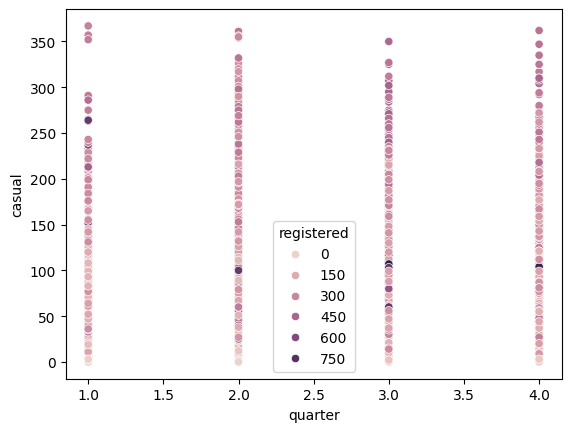

In [155]:
sns.scatterplot(data=bikeshare_new,x="quarter",y="casual",hue="registered")

### 1.3 Find numerical and categorical variables

In [156]:
# YOUR CODE HERE
num_col = []
cat_col = []
for key in bikeshare_new.keys():
    if bikeshare_new[key].dtype == "float64":
        num_col.append(key)
    else:
        cat_col.append(key)
print("Numerial column {}".format(num_col))
print("Categorical column {}".format(cat_col))

Numerial column ['temp', 'atemp', 'hum', 'windspeed']
Categorical column ['dteday', 'season', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'casual', 'registered', 'cnt', 'year', 'month', 'quarter']


## **2. Pipeline-Steps:**

Build custom classes which are compatible with Skearn pipeline for imputation, feature mapping, and any column specific operation.

### **A. Imputation**

#### Build a custom Imputation class compatible with Sklearn for handling missing values in `weekday` column.

- Find the number of NaN entries in the `weekday` column, and get their row indices
- Use the `dteday` column to extract day names
- Impute values for the missing row indices in `weekday` column with the day names extracted above

**Note that** the extracted day names will contain full names (eg. 'Monday'), and the `weekday` column contains only first three letters (eg. 'Mon').

In [157]:
bikeshare_new.head(2)

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,quarter
0,2012-11-05,winter,6am,No,Mon,Yes,Mist,6.10,3.0014,49.0,19.0012,4,135,139,2012,Nov,4
1,2011-07-13,fall,4am,No,Wed,Yes,Clear,26.78,28.9988,58.0,16.9979,0,5,5,2011,Jul,3


In [158]:
class WeekdayImputer(BaseEstimator, TransformerMixin):
    """ Impute missing values in 'weekday' column by extracting dayname from 'dteday' column """

    def __init__(self,featurename):
        # YOUR CODE HERE
        self.featurename = featurename

    def fit(self,X,y=None):
        # YOUR CODE HERE
        self.modeVal = X[self.featurename].mode()
        return self
        
    def transform(self,X,y=None):
        # YOUR CODE HERE
        X_new = X.copy()
        X_new[self.featurename] = X_new[self.featurename].fillna(self.modeVal[0])
        return X_new




In [159]:
# Apply weekday imputer

# YOUR CODE HERE
c = WeekdayImputer("weekday")
c.fit(bikeshare_new)
op = c.transform(bikeshare_new)
op["weekday"].isnull().sum()

0

#### Build another custom Imputation class compatible with Sklearn for handling missing values in `weathersit` column.

- Fill in the missing rows in this column with the most frequent category

In [160]:
bikeshare_new.weathersit.unique()

array(['Mist', 'Clear', nan, 'Light Rain', 'Heavy Rain'], dtype=object)

In [161]:

class WeathersitImputer(BaseEstimator, TransformerMixin):
    """ Impute missing values in 'weathersit' column by replacing them with the most frequent category value """

    def __init__(self,featurename):
        # YOUR CODE HERE
        self.featurename = featurename

    def fit(self,X,y=None):
        # YOUR CODE HERE
        self.modeVal = X[self.featurename].mode()
        return self
        
    def transform(self,X,y=None):
        # YOUR CODE HERE
        X_new = X.copy()
        X_new[self.featurename] = X_new[self.featurename].fillna(self.modeVal[0])
        return X_new


In [162]:
# Apply weathersit imputer

# YOUR CODE HERE
c = WeathersitImputer("weathersit")
c.fit(op)
op = c.transform(op)
op["weathersit"].isnull().sum()

0

In [163]:
op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  object 
 2   hr          17379 non-null  object 
 3   holiday     17379 non-null  object 
 4   weekday     17379 non-null  object 
 5   workingday  17379 non-null  object 
 6   weathersit  17379 non-null  object 
 7   temp        17379 non-null  float64
 8   atemp       17379 non-null  float64
 9   hum         17379 non-null  float64
 10  windspeed   17379 non-null  float64
 11  casual      17379 non-null  int64  
 12  registered  17379 non-null  int64  
 13  cnt         17379 non-null  int64  
 14  year        17379 non-null  int64  
 15  month       17379 non-null  object 
 16  quarter     17379 non-null  int64  
dtypes: float64(4), int64(5), object(8)
memory usage: 2.3+ MB


In [164]:
processed_op = op.copy()

In [165]:
processed_op.head(2)

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,quarter
0,2012-11-05,winter,6am,No,Mon,Yes,Mist,6.10,3.0014,49.0,19.0012,4,135,139,2012,Nov,4
1,2011-07-13,fall,4am,No,Wed,Yes,Clear,26.78,28.9988,58.0,16.9979,0,5,5,2011,Jul,3


### **B. Mapping**

#### Build a Mapper class for mapping `yr`, `mnth`, `season`, `weathersit`, `holday`, `workingday`, and `hr` columns.

In [166]:
yr_mapping = {2011: 0, 2012: 1}
mnth_mapping = {'Jan': 0, 'Feb': 1, 'Dec': 2, 'Mar': 3, 'Nov': 4, 'Apr': 5,
                'Oct': 6, 'May': 7, 'Sep': 8, 'Jun': 9, 'Jul': 10, 'Aug': 11}
season_mapping = {'spring': 0, 'winter': 1, 'summer': 2, 'fall': 3}
weathersit_mapping = {'Heavy Rain': 0, 'Light Rain': 1, 'Mist': 2, 'Clear': 3}
holday_mapping = {'Yes': 0, 'No': 1}
workingday_mapping = {'No': 0, 'Yes': 1}
hr_mapping = {'4am': 0, '3am': 1, '5am': 2, '2am': 3, '1am': 4, '12am': 5, '6am': 6, '11pm': 7, '10pm': 8,
                '10am': 9, '9pm': 10, '11am': 11, '7am': 12, '9am': 13, '8pm': 14, '2pm': 15, '1pm': 16,
                '12pm': 17, '3pm': 18, '4pm': 19, '7pm': 20, '8am': 21, '6pm': 22, '5pm': 23}

In [167]:

class Mapper(BaseEstimator, TransformerMixin):
    """
    Ordinal categorical variable mapper:
    Treat column as Ordinal categorical variable, and assign values accordingly
    """

    def __init__(self,featureName,mapping):
        # YOUR CODE HERE
        self.featureName = featureName
        self.mapping = mapping

    def fit(self,X,y=None):
        # YOUR CODE HERE
        return self


    def transform(self,X,y=None):
        # YOUR CODE HERE
        X_new = X.copy()
        X_new[self.featureName] = X_new[self.featureName].replace(self.mapping)
        return X_new


In [168]:
processed_op.head(1)

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,quarter
0,2012-11-05,winter,6am,No,Mon,Yes,Mist,6.1,3.0014,49.0,19.0012,4,135,139,2012,Nov,4


In [169]:
# Instantiate mapper for all ordinal categorical features

# YOUR CODE HERE
mapper = {"year":yr_mapping,"month":mnth_mapping,"season":season_mapping,"weathersit":weathersit_mapping,"holiday":holday_mapping,"workingday": workingday_mapping,"hr":hr_mapping}
for k in mapper.keys():
    m = Mapper(k,mapper[k])
    m.fit(processed_op)
    processed_op = m.transform(processed_op)

In [170]:
# Map values for all ordinal categorical features

# YOUR CODE HERE
processed_op.head(2)

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,quarter
0,2012-11-05,1,6,1,Mon,1,2,6.10,3.0014,49.0,19.0012,4,135,139,1,4,4
1,2011-07-13,3,0,1,Wed,1,3,26.78,28.9988,58.0,16.9979,0,5,5,0,10,3


In [171]:
processed_op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   hr          17379 non-null  int64  
 3   holiday     17379 non-null  int64  
 4   weekday     17379 non-null  object 
 5   workingday  17379 non-null  int64  
 6   weathersit  17379 non-null  int64  
 7   temp        17379 non-null  float64
 8   atemp       17379 non-null  float64
 9   hum         17379 non-null  float64
 10  windspeed   17379 non-null  float64
 11  casual      17379 non-null  int64  
 12  registered  17379 non-null  int64  
 13  cnt         17379 non-null  int64  
 14  year        17379 non-null  int64  
 15  month       17379 non-null  int64  
 16  quarter     17379 non-null  int64  
dtypes: float64(4), int64(11), object(2)
memory usage: 2.3+ MB


### **C. Class for Specific operation**

#### Build a Class for handling outliers in numerical columns

- Instead of removing the outliers, change their values
    - to upper-bound, if the value is higher than upper-bound, or
    - to lower-bound, if the value is lower than lower-bound respectively.

In [172]:

class OutlierHandler(BaseEstimator, TransformerMixin):
    """
    Change the outlier values:
        - to upper-bound, if the value is higher than upper-bound, or
        - to lower-bound, if the value is lower than lower-bound respectively.
    """

    def __init__(self,column,upperbound,lowerbound):
        # YOUR CODE HERE
        self.upper_bound = upperbound
        self.lower_bound = lowerbound
        self.column = column

    def fit(self,X,y=None):
        # YOUR CODE HERE
        return self

    def transform(self,X,y=None):
        # YOUR CODE HERE
        X_new = X.copy()
        q1 = X_new.describe()[self.column].loc[self.lower_bound]
        q3 = X_new.describe()[self.column].loc[self.upper_bound]
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        for i in X_new.index:
            if X_new.loc[i,self.column] > upper_bound:
                X_new.loc[i,self.column]= upper_bound
            if X_new.loc[i,self.column] < lower_bound:
                X_new.loc[i,self.column]= lower_bound

        return X_new

In [173]:
# Instantiate outlier handler for all numerical features

# YOUR CODE HERE
for col in num_col:
    outlier = OutlierHandler(col,"75%","25%")
    processed_op = outlier.transform(processed_op)

<Axes: >

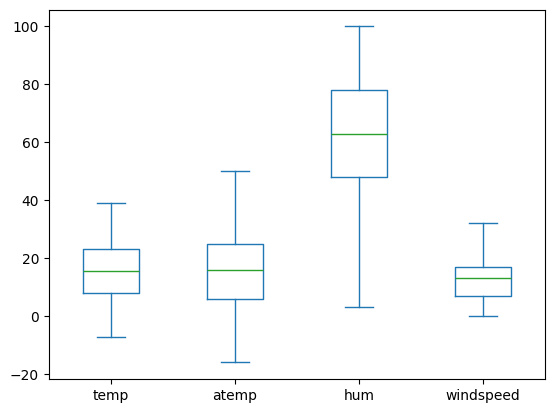

In [174]:
processed_op[num_col].plot(kind="box")

#### Build a Class to One-hot Encode `weekday` column

In [175]:

class WeekdayOneHotEncoder(BaseEstimator, TransformerMixin):
    """ One-hot encode weekday column """

    def __init__(self,column):
        # YOUR CODE HERE
        self.column = column
        self.encoder = OneHotEncoder(sparse_output=False)

    def fit(self,X,y=None):
        # YOUR CODE HERE
        return self

    def transform(self,X,y=None):
        # YOUR CODE HERE
        X_new = X.copy()
        self.encoder.fit(X_new[[self.column]])
        feature_names = self.encoder.get_feature_names_out()
        X_new = self.encoder.transform(X_new[[self.column]])
        X[feature_names] = X_new
        X.drop("weekday",axis=1,inplace=True)
        return X


In [176]:
processed_op

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,quarter
0,2012-11-05,1,6,1,Mon,1,2,6.10,3.0014,49.0,19.0012,4,135,139,1,4,4
1,2011-07-13,3,0,1,Wed,1,3,26.78,28.9988,58.0,16.9979,0,5,5,0,10,3
2,2012-02-09,0,11,1,Thu,1,3,3.28,-0.9982,52.0,15.0013,4,95,99,1,1,1
3,2012-03-22,2,12,1,Thu,1,2,14.56,15.0002,100.0,6.0032,29,332,361,1,3,1
4,2011-11-08,1,17,1,Tue,1,3,16.44,17.0000,52.0,8.9981,28,175,203,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2011-05-24,2,16,1,Tue,1,3,28.66,30.0020,46.0,16.9979,38,152,190,0,7,2
17375,2012-04-19,2,10,1,Thu,1,3,16.44,17.0000,55.0,7.0015,27,240,267,1,5,2
17376,2012-01-24,0,7,1,Tue,1,3,7.04,7.0010,76.0,0.0000,19,80,99,1,0,1
17377,2011-01-22,0,4,1,Sat,0,2,-6.12,-16.0000,41.0,26.0027,3,9,12,0,0,1


In [177]:
# Treat 'weekday' column as a Categorical variable, perform one-hot encoding

# YOUR CODE HERE
weekday = WeekdayOneHotEncoder("weekday")
processed_op_new = processed_op.copy()
processed_op_new = weekday.transform(processed_op_new)
processed_op_new

,dteday,season,hr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,...,year,month,quarter,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
0,2012-11-05,1,6,1,1,2,6.10,3.0014,49.0,19.0012,...,1,4,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2011-07-13,3,0,1,1,3,26.78,28.9988,58.0,16.9979,...,0,10,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2012-02-09,0,11,1,1,3,3.28,-0.9982,52.0,15.0013,...,1,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2012-03-22,2,12,1,1,2,14.56,15.0002,100.0,6.0032,...,1,3,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2011-11-08,1,17,1,1,3,16.44,17.0000,52.0,8.9981,...,0,4,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2011-05-24,2,16,1,1,3,28.66,30.0020,46.0,16.9979,...,0,7,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17375,2012-04-19,2,10,1,1,3,16.44,17.0000,55.0,7.0015,...,1,5,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17376,2012-01-24,0,7,1,1,3,7.04,7.0010,76.0,0.0000,...,1,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17377,2011-01-22,0,4,1,0,2,-6.12,-16.0000,41.0,26.0027,...,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## **3. Build Pipeline**

Build a pipeline and implement all the above class transformers inside the pipeline along with the regressor.

In [178]:
num_col

['temp', 'atemp', 'hum', 'windspeed']

In [179]:
# YOUR CODE HERE
bikesharing_pipe=Pipeline([

    ("WeekdayImputer",WeekdayImputer("weekday")),
    ("weathersit",WeathersitImputer("weathersit")),
    ##==========Mapper======##
    ("yearMap",Mapper("year",yr_mapping)),
    ("monthMap",Mapper("month",mnth_mapping)),
    ("seasonMap",Mapper("season",season_mapping)),
    ("weathersitMap",Mapper("weathersit",weathersit_mapping)),
    ("holidayMap",Mapper("holiday",holday_mapping)),
    ("workingdayMap",Mapper("workingday",workingday_mapping)),
    ("hrMap",Mapper("hr",hr_mapping)),
    # Outlier handler
    ("tempOutlierHandler",OutlierHandler("temp","75%","25%")),
    ("atempOutlierHandler",OutlierHandler("atemp","75%","25%")),
    ("humOutlierHandler",OutlierHandler("hum","75%","25%")),
    ("windspeedOutlierHandler",OutlierHandler("windspeed","75%","25%")),

    # Weekday OneHotEncoder
    ("WeekdayOneHotEncoder",WeekdayOneHotEncoder("weekday")),

    # scale
    ('scaler', StandardScaler()),
    ('model_rf', RandomForestRegressor(n_estimators=150, max_depth=5,random_state=42))
])

## **4. Fit Pipeline**

- Separate target and prediction features
- Split data into train and test set
- Fit pipeline on train set
- Get prediction on test set
- Calculate the mse and r2_score

In [180]:
# YOUR CODE HERE
processed_op_new.head(1)

,dteday,season,hr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,...,year,month,quarter,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
0,2012-11-05,1,6,1,1,2,6.1,3.0014,49.0,19.0012,...,1,4,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [191]:
processed_op_new.keys()

Index(['dteday', 'season', 'hr', 'holiday', 'workingday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'year',
       'month', 'quarter', 'weekday_Fri', 'weekday_Mon', 'weekday_Sat',
       'weekday_Sun', 'weekday_Thu', 'weekday_Tue', 'weekday_Wed'],
      dtype='object')

In [192]:
bikeshare_new.keys()

Index(['dteday', 'season', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'year', 'month', 'quarter'],
      dtype='object')

In [182]:
X = bikeshare_new.drop(["dteday","cnt",],axis=1) # prediction variables
y = bikeshare_new["cnt"] # target variable

In [183]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [184]:
X_train.shape,y_train.shape

((13903, 15), (13903,))

In [185]:
bikesharing_pipe.fit(X_train,y_train)
y_pred=bikesharing_pipe.predict(X_test)
print(y_pred)


[ 38.76161843  27.89816524  57.11628996 ... 186.60329085 417.42087642
 197.92944108]


In [186]:
# Calculate the r2 score
print("r2_score(in %):", r2_score(y_test, y_pred)*100)

r2_score(in %): 99.36638431506275


In [187]:
# Calculate the mean squared error
print("mean squared error :", mean_squared_error(y_test, y_pred))

mean squared error : 214.63456114907095


### Check for package versions may be used for requirements.txt file

In [188]:
!pip -qq install pydantic
!pip -qq install strictyaml
!pip -qq install ruamel.yaml

In [189]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import pydantic
import strictyaml
import ruamel.yaml
import joblib

In [190]:
# YOUR CODE HERE
print(np.__version__)
print(pd.__version__)
print(sns.__version__)
print(sklearn.__version__)
print(pydantic.__version__)
print(strictyaml.__version__)
print(ruamel.yaml.__version__)
print(joblib.__version__)

1.26.3
1.5.3
0.13.1
1.3.0
1.10.13
1.6.2
0.18.5
1.3.2


## **5. Modularize the application**

- Convert the above regression application to a production environment format (.py files) inside VS code.

- Create different modules specific to functionality:
    - requirements
    - configuration
    - data manager
    - feature engineering
    - pipeline building
    - pipeline training
    - predict
